In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import seaborn as sns
import cmlreaders as cml
import cmldask.CMLDask as da
import os
import traceback
from ptsa.data.filters import ResampleFilter, ButterworthFilter, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries
save_path = '/data7/rsa_class'

# Computing Correlations Using xarray

First we are going to try to demonstrate how to compute a correlation by "hand" and then how to compute it efficiently using xarray.

As a simple example, imagine we are looking at the brain while people look at states like in the Chipman and Shepard (1970) paper from lecture). Generate a dataset where we observe 10 neural features across 15 states

In [2]:
A = np.diag(np.ones(15))  # a diagonal covariance matrix

In [3]:
A

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

Add in a couple true correlations across "states"

In [4]:
A[1, 2] = A[2, 1] = .5
A[6, 8] = A[6, 8] = .8
A

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 1. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0.5, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0.8, 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
       

In [5]:
features = np.random.multivariate_normal(size=10, mean=np.zeros(15), cov=A).T

/tmp/ipykernel_80346/3651426059.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  features = np.random.multivariate_normal(size=10, mean=np.zeros(15), cov=A).T


Now we want to look at two sets of features and see how similar they are

In [6]:
features[1], features[2]

(array([-0.42195266, -1.14316557,  0.13208253,  1.4317144 , -1.7296228 ,
         0.08355146,  0.64419187, -0.04518374, -0.09451543, -0.12961003]),
 array([ 0.29693597, -0.66813372,  0.1977062 ,  1.60863947,  0.07052268,
         0.01162864, -0.38585939,  1.10135484,  0.5557675 ,  0.08234905]))

Generally feature 1 is negative when feature 2 is negative and positive when feature 2 is positive so they seem pretty similar (this is because we made them similar when we generated the covariance matrix). This should be reflected when we compute their correlation. [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is the covariance of the two variables divided by the standard deviation of each multiplied together.

Covariance is the expectation (aka expected value aka mean) of (feature 1 - mean(feature 1)) * (feature 2 - mean(feature 2). This measure is going to be high if feature 1 is usually above its mean when feature 2 is also above its mean. Lets compute it

In [7]:
np.mean(features[1]), np.mean(features[2])

(-0.1272509979917849, 0.287091124046894)

In [8]:
(features[1] - np.mean(features[1])) * (features[2] - np.mean(features[2]))

array([-2.90129251e-03,  9.70426836e-01, -2.31805079e-02,  2.06024815e+00,
        3.47023163e-01, -5.80681672e-02, -5.19142874e-01,  6.68243866e-02,
        8.79527287e-03,  4.82993420e-04])

Now we take the average of that value (but its a sample statistic so we use n-1 in the denominator, instead of n=10)

In [9]:
feat_cov = (np.sum((features[1] - np.mean(features[1])) * 
        (features[2] - np.mean(features[2]))) / (10 - 1)) 
feat_cov 

0.3167231063336258

We can check it against `numpy`'s version

In [10]:
np.cov(features[1], features[2])

array([[0.75905865, 0.31672311],
       [0.31672311, 0.44664519]])

Now just divide that by the sample standard deviations

In [11]:
feat_cov / (np.std(features[1], ddof=1) * np.std(features[2], ddof=1))

0.5439522178061897

And check that against numpy's versiosn of correlation

In [12]:
np.corrcoef(features[1], features[2])

array([[1.        , 0.54395222],
       [0.54395222, 1.        ]])

Now we want a way to compute these correlations for all of the states and keep track of all of the state info. Like we do with EEG, we'll store it using an xarray DataArray

In [13]:
states_da = xr.DataArray(data=features, 
             dims=["states", "features"], 
             coords={'features': ['feat_' + str(i) for i in range(10)],
                     'states': ['Minn.', 'Ore.', 'W.V.', 'Colo.', 'Ala.', 'Ill.',
                               'Nev.', 'Nebr.', 'Okla.', 'Ida.', 'Fla.', 'La.', 
                                'S.C.', 'Mo.', 'Me.']})

In [14]:
states_da

<xarray.DataArray (states: 15, features: 10)>
array([[-1.14843366, -2.17079084, -0.2282922 ,  0.08996026,  1.23422173,
         1.58720084, -0.94213502,  0.30464815,  1.06261293, -0.2484342 ],
       [-0.42195266, -1.14316557,  0.13208253,  1.4317144 , -1.7296228 ,
         0.08355146,  0.64419187, -0.04518374, -0.09451543, -0.12961003],
       [ 0.29693597, -0.66813372,  0.1977062 ,  1.60863947,  0.07052268,
         0.01162864, -0.38585939,  1.10135484,  0.5557675 ,  0.08234905],
       [-0.18326577, -0.0955466 , -0.84262116, -0.49176993, -0.63949582,
        -0.46133198,  0.03356775,  0.52872575,  0.27394336, -1.02765781],
       [-1.41135427,  1.0057875 ,  0.40880328, -1.64418017,  0.78715509,
        -0.14690577, -1.64500873, -1.37068155, -0.04397012, -0.6956429 ],
       [-0.34014389, -1.93289968,  1.17224547,  0.35545058, -1.11163452,
         1.19745187,  0.68825367, -0.20230453,  0.18182986, -0.59927704],
       [ 0.20378684, -0.42808622, -1.29626103,  1.29208375,  0.43886385,
         1.30270035, -0.98606283,  0.49342844,  0.40246208, -1.33733643],
       [ 0.52836015, -1.5259827 , -0.06982171, -0.72990648, -1.14151129,
        -0.32481403,  0.34696061, -0.33095442, -1.60960574,  0.94646279],
       [ 1.19256144, -0.377124  , -0.95017737,  1.75969085, -0.71013462,
        -0.67387161,  0.29093025,  0.51307734,  0.42520984, -0.72738162],
       [ 0.037174  , -0.7516586 ,  1.15635278, -0.41190199, -0.95758567,
         1.29719018, -0.1946514 , -0.67871468,  1.81452862,  0.45184014],
       [ 0.87606891, -0.20762068,  0.00656965, -0.12870202,  0.19201927,
        -1.42863966,  0.59415821,  0.43620066, -0.11951924, -0.82813794],
       [-0.05867057,  1.17234122, -1.05257566, -0.01616835,  0.13713519,
         0.98341125, -1.44654495, -0.47338135, -0.11881636,  2.44550161],
       [ 0.1695933 , -0.81398151,  0.64192629,  0.46759156,  0.32938111,
        -0.45204878,  0.0229592 , -0.28498422,  0.48309163,  0.96450131],
       [ 0.28496161, -0.96414636,  0.82759391,  0.89878348, -0.38713097,
         0.79430369,  0.60849266, -1.229362  , -0.28736287, -1.09484773],
       [ 1.19635412, -0.42688134,  0.53307788, -0.0482305 , -0.96137665,
         0.97329867,  0.2210466 , -1.30863823, -0.14507083, -0.57076226]])
Coordinates:
  * features  (features) <U6 'feat_0' 'feat_1' 'feat_2' ... 'feat_8' 'feat_9'
  * states    (states) <U5 'Minn.' 'Ore.' 'W.V.' 'Colo.' ... 'S.C.' 'Mo.' 'Me.'

Now we can use the xr.corr function to compute the correlation of features between states but its not so straightforward because the states have the same names in both -- just plugging it in like this leads to the wrong answer because it matches the array along its dimensions. This leads to just correlates each state with itself, which is going to  always be 1

In [15]:
xr.corr(states_da, states_da, dim='features')

<xarray.DataArray (states: 15)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Coordinates:
  * states   (states) <U5 'Minn.' 'Ore.' 'W.V.' 'Colo.' ... 'S.C.' 'Mo.' 'Me.'

What we want is each state correlated with every other one. We need to rename the states variable to get the right answer

In [16]:
states_da2 = states_da.rename({'states': 'states2'})

In [17]:
states_corr = xr.corr(states_da, states_da2, dim='features')

In [18]:
states_corr

<xarray.DataArray (states: 15, states2: 15)>
array([[ 1.        ,  0.03441832,  0.38643505, -0.07976265,  0.09105109,
         0.42902949,  0.54000149, -0.2001398 , -0.16359479,  0.39857437,
        -0.41862503,  0.00407398,  0.24416662,  0.16153197, -0.1013232 ],
       [ 0.03441832,  1.        ,  0.54395222,  0.04505798, -0.71879028,
         0.70270642,  0.11988758,  0.32194749,  0.53092095,  0.27405009,
        -0.06846273, -0.29837119,  0.24861438,  0.55290039,  0.3083636 ],
       [ 0.38643505,  0.54395222,  1.        ,  0.15943397, -0.52147548,
         0.27804868,  0.54802347, -0.05533194,  0.65584101, -0.01827702,
         0.118318  , -0.18986529,  0.3304217 ,  0.12582951, -0.18314454],
       [-0.07976265,  0.04505798,  0.15943397,  1.        , -0.28096961,
        -0.07873268,  0.30313415, -0.35616486,  0.46340679, -0.12017062,
         0.44906319, -0.42544936, -0.53697489, -0.25667716, -0.20474754],
       [ 0.09105109, -0.71879028, -0.52147548, -0.28096961,  1.        ,
        -0.36757624, -0.14708579, -0.57070211, -0.7336755 ,  0.12368646,
        -0.347708  ,  0.27980789, -0.17137721, -0.22435228, -0.15465711],
       [ 0.42902949,  0.70270642,  0.27804868, -0.07873268, -0.36757624,
         1.        ,  0.09943432,  0.32588167,  0.05757196,  0.63026963,
        -0.18183588, -0.4693994 ,  0.24743514,  0.75142459,  0.54908603],
       [ 0.54000149,  0.11988758,  0.54802347,  0.30313415, -0.14708579,
         0.09943432,  1.        , -0.44594338,  0.47455692, -0.05466285,
...
         0.05757196,  0.47455692, -0.01884356,  1.        , -0.2248089 ,
         0.48722261, -0.31236974,  0.00977628,  0.21579395,  0.12198557],
       [ 0.39857437,  0.27405009, -0.01827702, -0.12017062,  0.12368646,
         0.63026963, -0.05466285,  0.05484929, -0.2248089 ,  1.        ,
        -0.45779029,  0.02705076,  0.31851429,  0.34406729,  0.51532152],
       [-0.41862503, -0.06846273,  0.118318  ,  0.44906319, -0.347708  ,
        -0.18183588, -0.1662455 ,  0.06662939,  0.48722261, -0.45779029,
         1.        , -0.67659362,  0.02921328, -0.02658268, -0.08375413],
       [ 0.00407398, -0.29837119, -0.18986529, -0.42544936,  0.27980789,
        -0.4693994 ,  0.00321205,  0.06405049, -0.31236974,  0.02705076,
        -0.67659362,  1.        ,  0.02097718, -0.48349462, -0.15823967],
       [ 0.24416662,  0.24861438,  0.3304217 , -0.53697489, -0.17137721,
         0.24743514, -0.32662798,  0.36732884,  0.00977628,  0.31851429,
         0.02921328,  0.02097718,  1.        ,  0.13380128, -0.01197139],
       [ 0.16153197,  0.55290039,  0.12582951, -0.25667716, -0.22435228,
         0.75142459,  0.2110822 ,  0.1401289 ,  0.21579395,  0.34406729,
        -0.02658268, -0.48349462,  0.13380128,  1.        ,  0.76312364],
       [-0.1013232 ,  0.3083636 , -0.18314454, -0.20474754, -0.15465711,
         0.54908603,  0.05137372,  0.32734426,  0.12198557,  0.51532152,
        -0.08375413, -0.15823967, -0.01197139,  0.76312364,  1.        ]])
Coordinates:
  * states   (states) <U5 'Minn.' 'Ore.' 'W.V.' 'Colo.' ... 'S.C.' 'Mo.' 'Me.'
  * states2  (states2) <U5 'Minn.' 'Ore.' 'W.V.' 'Colo.' ... 'S.C.' 'Mo.' 'Me.'

In [19]:
states_corr_df = states_corr.to_dataframe('corr').reset_index()
states_corr_df

,states,states2,corr
0,Minn.,Minn.,1.000000
1,Minn.,Ore.,0.034418
2,Minn.,W.V.,0.386435
3,Minn.,Colo.,-0.079763
4,Minn.,Ala.,0.091051
...,...,...,...
220,Me.,Fla.,-0.083754
221,Me.,La.,-0.158240
222,Me.,S.C.,-0.011971
223,Me.,Mo.,0.763124


This is the same as we calculated before!

In [20]:
states_corr_df.query('states == "Ore." and states2 == "W.V."')

,states,states2,corr
17,Ore.,W.V.,0.543952


# Computing correlations in EEG data

In [21]:
subs = ['R1045E', 'R1102P', 'R1108J', 'R1141T', 'R1144E', 'R1157C',
       'R1192C', 'R1202M', 'R1226D', 'R1236J', 'R1269E', 'R1277J',
       'R1291M', 'R1310J', 'R1328E', 'R1330D', 'R1337E', 'R1351M',
       'R1354E', 'R1361C', 'R1375C', 'R1383J', 'R1389J', 'R1390M',
       'R1395M', 'R1401J', 'R1403N', 'R1412M', 'R1465D', 'R1468J',
       'R1474T', 'R1476J', 'R1477J', 'R1482J', 'R1486J', 'R1490T',
       'R1497T', 'R1501J', 'R1515T', 'R1525J', 'R1527J', 'R1530J',
       'R1536J', 'R1541T']

In [22]:
ix = cml.get_data_index()
exp = 'catFR1'
exp_ix = ix.query('experiment == @exp and subject == @subs')

## Preprocess data

We first load the data and preprocess into power at different frequency bands both during encoding (300ms to 1300 ms after the word appears on screen) and right before retrieval (900 to 100ms before vocalization). In order to make signals comparable across encoding and retrieval, we standardize both of them by data from during the 10s countdown periods that preceded each list. This means that all of the data is relative to the countdown period (e.g. there is .5 standard deviations more power in the 3 Hz band than the average of the countdown period).

In [23]:
sub = 'R1045E'
df = cml.get_data_index('r1', '/')

enc_range_left_ms = 300
enc_range_right_ms = 1300
morlet_reps = 6
freqs = np.logspace(np.log10(3), np.log10(180), 8)
resameplerate = 500
enc_buffer_time = (morlet_reps / 2) * (1000 / min(freqs))

df_sub = df.query('subject == @sub and experiment == "catFR1"').iloc[:1]
reader = cml.CMLReader(subject=sub, session=df_sub.session.item(), experiment=df_sub.experiment.item(),
                   localization=df_sub.localization.item(), montage=df_sub.montage.item())
pairs = reader.load('pairs')
evs = reader.load('events')

enc_evs = evs.query('type == "WORD" and eegoffset != -1')
enc_evs = enc_evs[enc_evs['list'] > 0]
enc_evs['category'] = enc_evs ['category'].str.lower()
enc_evs = enc_evs.iloc[:25]

eeg = reader.load_eeg(events=enc_evs, rel_start=enc_range_left_ms-enc_buffer_time, \
                      rel_stop=enc_range_right_ms+enc_buffer_time, scheme=pairs)

eeg_ptsa = eeg.to_ptsa()

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/readers/electrodes.py:237: MissingCoordinatesWarning: Could not load MNI coordinates
  warnings.warn(cmlreaders.warnings.MissingCoordinatesWarning(


In [24]:
# centering signal within event
# reduce edge effects / ringing in later processing steps:
eeg_ptsa = eeg_ptsa.astype(float) - eeg_ptsa.mean('time')
# filter out line noise at 60 Hz
eeg_ptsa = ButterworthFilter(filt_type='stop', 
                        freq_range=[58, 62], 
                        order=4).filter(timeseries=eeg_ptsa)
# compute spectral features!
wf = MorletWaveletFilter(freqs=freqs, width=morlet_reps, output='power', complete=True)
# freqs, events, elecs, and time
powers = wf.filter(eeg_ptsa)

CPP total time wavelet loop:  1.5913777351379395


In [25]:
powers.data = np.log10(powers.data)
powers

<xarray.TimeSeries (frequency: 8, event: 25, channel: 109, time: 2996)>
array([[[[4.76698658, 4.76837155, 4.76983572, ..., 5.54551823,
          5.54236658, 5.53920995],
         [5.26733142, 5.2696319 , 5.2719315 , ..., 5.75266228,
          5.75048357, 5.74829783],
         [5.79720135, 5.7984041 , 5.79960466, ..., 5.66487594,
          5.66164329, 5.65840377],
         ...,
         [7.42371459, 7.4252635 , 7.42680657, ..., 7.23797571,
          7.23771718, 7.23744412],
         [8.0730876 , 8.07455616, 8.07601977, ..., 7.66902121,
          7.66974936, 7.67046042],
         [6.95665514, 6.95914469, 6.9616686 , ..., 7.4421983 ,
          7.44137383, 7.44054555]],

        [[6.29680283, 6.29773813, 6.2986665 , ..., 5.8095292 ,
          5.80688945, 5.80424107],
         [6.25504632, 6.25616804, 6.25728279, ..., 5.04261047,
          5.04198665, 5.04135961],
         [6.24923723, 6.25056288, 6.25188073, ..., 5.62650455,
          5.62530809, 5.62410542],
...
         [4.82416156, 4.80698482, 4.76908004, ..., 5.53752147,
          5.59770832, 5.63049257],
         [6.16943301, 6.15169855, 6.10301215, ..., 4.08423835,
          4.21804311, 4.30355384],
         [3.79268563, 3.83195721, 3.85911613, ..., 5.2938577 ,
          5.41181234, 5.4865739 ]],

        [[3.83426593, 3.89587473, 3.9406835 , ..., 3.67078452,
          3.58820491, 3.48871817],
         [3.86000907, 3.97933348, 4.07867495, ..., 4.01986538,
          4.00345129, 3.95946936],
         [3.71246538, 3.8065744 , 3.89274212, ..., 4.44216539,
          4.35617906, 4.24257741],
         ...,
         [4.02072673, 4.07731805, 4.12568859, ..., 4.52433797,
          4.60461783, 4.65976923],
         [6.47338594, 6.45389213, 6.40024712, ..., 5.48008215,
          5.57389463, 5.63347391],
         [6.54323639, 6.5275412 , 6.47956407, ..., 6.51611073,
          6.59356775, 6.63962062]]]])
Coordinates: (12/31)
  * event         (event) object MultiIndex
  * answer        (event) int64 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
  * category      (event) object 'officesupplies' ... 'electronics'
  * category_num  (event) int64 17 17 14 14 3 3 17 17 3 ... 6 15 15 6 6 23 23 7
  * eegfile       (event) object '/protocols/r1/subjects/R1045E/experiments/c...
  * eegoffset     (event) int64 491162 493597 495997 ... 636895 639329 710970
    ...            ...
  * test          (event) object (0, 0, 0) (0, 0, 0) ... (0, 0, 0) (0, 0, 0)
  * type          (event) object 'WORD' 'WORD' 'WORD' ... 'WORD' 'WORD' 'WORD'
  * channel       (channel) <U16 'LAFS1-LAFS2' 'LAFS2-LAFS3' ... 'RPHGD5-RPHGD7'
  * time          (time) float64 -700.0 -699.0 -698.0 ... 2.297e+03 2.298e+03
    samplerate    float64 999.0
  * frequency     (frequency) float64 3.0 5.384 9.664 ... 55.88 100.3 180.0

In [26]:
print('resample rate', resameplerate)
powers = ResampleFilter(resamplerate=resameplerate).filter(
    timeseries=powers)
powers = powers.remove_buffer(enc_buffer_time / 1000)

# reshape as events x features
powers = powers.stack(features=("channel", "frequency"))

resample rate 500


In [27]:
powers.indexes['event'].names

FrozenList(['answer', 'category', 'category_num', 'eegfile', 'eegoffset', 'exp_version', 'experiment', 'intrusion', 'is_stim', 'iscorrect', 'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime', 'protocol', 'recalled', 'rectime', 'serialpos', 'session', 'stim_list', 'stim_params', 'subject', 'test', 'type'])

In [28]:
# need to remove stim_params because of issues with converting to pandas DataFrame
if 'stim_params' in powers.indexes['event'].names:
    powers = powers.assign_coords(
        {"event": powers.indexes['event'].droplevel('stim_params')}
    )

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/xarray/core/common.py:615: FutureWarning: Updating MultiIndexed coordinate 'event' would corrupt indices for other variables: ['answer', 'category', 'category_num', 'eegfile', 'eegoffset', 'exp_version', 'experiment', 'intrusion', 'is_stim', 'iscorrect', 'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime', 'protocol', 'recalled', 'rectime', 'serialpos', 'session', 'stim_list', 'stim_params', 'subject', 'test', 'type']. This will raise an error in the future. Use `.drop_vars({'protocol', 'mstime', 'type', 'recalled', 'list', 'exp_version', 'eegfile', 'msoffset', 'intrusion', 'answer', 'eegoffset', 'test', 'montage', 'experiment', 'is_stim', 'serialpos', 'stim_params', 'category', 'event', 'item_name', 'rectime', 'iscorrect', 'stim_list', 'session', 'item_num', 'subject', 'category_num'})` before assigning new coordinate values.
  data.coords.update(results)


## Preprocess recall events

In [29]:
rec_range_left_ms = -900
rec_range_right_ms = -100
rec_buffer_time = 760

In [30]:
eeg_ptsa

<xarray.TimeSeries (event: 25, channel: 109, time: 2996)>
array([[[ 9.07564493e+00,  8.91269333e+00,  7.78982271e+00, ...,
         -6.73819109e-01, -1.87117464e+00, -7.41286306e-02],
        [-2.41358269e-01, -1.06808596e+00,  5.58388921e-02, ...,
          6.17264351e-01,  7.38114355e-01, -2.16292342e+00],
        [-1.78423067e+00, -1.86807224e+00, -5.95247050e+00, ...,
          2.94886808e+00,  8.09032297e-01, -2.80513706e-01],
        ...,
        [-2.24676236e+01, -2.20258621e+01, -2.66083894e+01, ...,
          1.96299162e+01,  2.41579243e+01,  3.07893597e+01],
        [-6.65766688e+00, -2.37185228e+00,  4.77603047e+00, ...,
         -3.21688971e+01, -3.65799464e+01, -4.09612498e+01],
        [-7.82027343e+00, -1.26559781e+01, -1.33940386e+01, ...,
          5.05643902e+01,  5.60168139e+01,  5.63652462e+01]],

       [[-3.38053776e+00, -5.53729369e+00,  1.32428359e+00, ...,
         -1.59123144e+00, -2.78913482e+00, -3.07713927e+00],
        [ 2.20039630e+00,  1.80903284e-01,  1.17953354e+00, ...,
          5.36357579e+00,  2.50743427e+00,  1.62261419e+00],
        [-6.26592442e+00, -2.32556354e+00, -5.39314791e+00, ...,
          2.82679465e+00,  4.69374759e+00,  6.54390395e+00],
...
        [ 2.22690152e+01,  2.23792903e+01,  2.76467132e+01, ...,
          4.30307265e+01,  4.16097071e+01,  4.80597664e+01],
        [-8.78085138e+01, -9.15945719e+01, -9.34250001e+01, ...,
          2.26051479e+00,  7.98647529e+00,  9.70564080e+00],
        [-1.90823222e+00,  4.11886671e+00,  8.19484822e+00, ...,
         -4.43647335e+01, -4.76717534e+01, -4.39332957e+01]],

       [[ 3.46525556e+00,  2.67293505e+00, -1.84780437e-01, ...,
          3.10392949e-03, -1.92384541e+00,  1.67094468e-01],
        [-1.00597547e+00, -3.06064247e+00,  1.91805484e+00, ...,
          5.23218025e+00,  3.23524652e+00,  3.22686822e+00],
        [-6.20852043e+00, -2.36264060e+00, -7.50220507e+00, ...,
         -4.33676943e+00,  5.13274023e-01, -1.60446468e+00],
        ...,
        [ 7.24180938e+00,  3.51565233e+00,  6.80312768e+00, ...,
          1.12593874e+01,  1.41993560e+01,  1.62463436e+01],
        [ 1.18972840e+02,  1.21403893e+02,  1.12696600e+02, ...,
         -4.98330170e+01, -5.13540185e+01, -4.99439155e+01],
        [-1.31323141e+02, -1.29884174e+02, -1.29432126e+02, ...,
          1.47524206e+02,  1.47774399e+02,  1.50136671e+02]]])
Coordinates: (12/30)
  * event         (event) object MultiIndex
  * answer        (event) int64 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
  * category      (event) object 'officesupplies' ... 'electronics'
  * category_num  (event) int64 17 17 14 14 3 3 17 17 3 ... 6 15 15 6 6 23 23 7
  * eegfile       (event) object '/protocols/r1/subjects/R1045E/experiments/c...
  * eegoffset     (event) int64 491162 493597 495997 ... 636895 639329 710970
    ...            ...
  * subject       (event) object 'R1045E' 'R1045E' ... 'R1045E' 'R1045E'
  * test          (event) object (0, 0, 0) (0, 0, 0) ... (0, 0, 0) (0, 0, 0)
  * type          (event) object 'WORD' 'WORD' 'WORD' ... 'WORD' 'WORD' 'WORD'
  * channel       (channel) <U16 'LAFS1-LAFS2' 'LAFS2-LAFS3' ... 'RPHGD5-RPHGD7'
  * time          (time) float64 -700.0 -699.0 -698.0 ... 2.297e+03 2.298e+03
    samplerate    float64 999.0

In [31]:
rec_evs = evs.query('type == "REC_WORD" and eegoffset != -1')
rec_evs = rec_evs[rec_evs['list'] > 0]
rec_evs['category'] = rec_evs ['category'].str.lower()
rec_evs = rec_evs.iloc[:25]
# get inter-retreival times since previous recall
rec_evs['pirt'] = rec_evs.groupby(['session', 'list'])['rectime'].diff().fillna(
    rec_evs['rectime'])
rec_evs['repeat'] = rec_evs.duplicated(subset=['session', 'list', 'item_name'])
rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
# only include recalls at least 1500 ms away and no repeats
rec_evs = rec_evs.query('pirt > 1500 and repeat == 0')

**Load EEG using PTSA just like above**

Because recalls might run into each other, in order to create a buffer, we need to use what's known as a mirror buffer. This ensures that future vocalizations don't screw up the buffer period

In [32]:
eeg_ptsa['time'] = eeg_ptsa['time'] / 1000 # PTSA time scale is in seconds instead of ms
eeg_ptsa = eeg_ptsa.add_mirror_buffer(rec_buffer_time/1000)
eeg_ptsa['time'] = eeg_ptsa['time'] * 1000

**Preprocess data just like above**

## Preprocess countdown events

In [33]:
countdown_rel_start = 0
countdown_rel_stop = 10000
countdown_resameplerate = 1

row = df_sub.iloc[0]
countdown_events = pd.read_csv(save_path+'/'+exp+'_countdown_evs.csv')
countdown_evs = countdown_events.query('subject == @row.subject and session == @row.session')

/tmp/ipykernel_80346/1931903411.py:6: DtypeWarning: Columns (6,9,18,26) have mixed types. Specify dtype option on import or set low_memory=False.
  countdown_events = pd.read_csv(save_path+'/'+exp+'_countdown_evs.csv')


**Preprocess data for countdown events just like above**

## Compute RSA

Now we have to compute the RSA. This basically involves loading the outputs of the `compute_features` function above and using the xarray `corr` function which will compute the correlation matrix between two data arrays and hold on to all the relevant information for us. There are two tricky things going on here. One is that we need to normalize the encoding and retrieval time features by the countdown features. we have a function called `normalize_features` to do that. We also need to change the names of the event information so that they don't match. If they do, the `corr` function will assume they are referring to the same informaiton and will not compute a correlation between them. In order to distinguish the item_name at retrieval and at encoding, we append the event `type` onto the name of each column. If we are computing the correlation between two events of the same `type` (e.g. each encoding event to other encoding events), we add a 2 on the end to distinguish them.

In [34]:
experiment = "catFR1"
encoding_type = "WORD"
comparison_type = "WORD"
countdown_normalize = 1

In [35]:
def normalize_features(pows, save_path, countdown_normalize=True):
    subject, session = pows.event.subject.values[0], pows.event.session.values[0]
    if countdown_normalize:
        countdown_fp = save_path + '/' + subject + '_' + str(session) + '_COUNTDOWN_START_feats.h5'
        countdown_pows = TimeSeries.from_hdf(countdown_fp)
        countdown_pows['samplerate'] = pows['samplerate']
        pows = (pows - countdown_pows.mean(['event', 'time'])) / countdown_pows.std(['event', 'time']) 
    else:
        pows = pows.reduce(func=sp.stats.zscore, dim='event', keep_attrs=True, ddof=1)
    return pows

def set_event_names(pows, period_type, col='event', copy=False):
    if copy:
        pows = pows.copy()
    events_mi = pows[col].to_index()
    events_mi = events_mi.rename(
        [name+'_'+period_type for name in events_mi.names])
    pows[col] = events_mi
    pows = pows.rename({col: col+'_'+period_type})
    return pows

In [36]:
print("Processing subject:", row.subject, "session:", row.session)

Processing subject: R1045E session: 0


In [37]:
encoding_fp = save_path + '/' + row.subject + '_' + str(row.session) + '_' + encoding_type + '_feats.h5'
encoding_pows = TimeSeries.from_hdf(encoding_fp)
encoding_pows = normalize_features(encoding_pows, save_path, countdown_normalize=True)

In [38]:
#need to rename event index to keep track of things for correlation matrix
comparison_pows = set_event_names(encoding_pows, encoding_type+'2', col='event', copy=True)
encoding_pows = set_event_names(encoding_pows, encoding_type, col='event')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/xarray/core/coordinates.py:41: FutureWarning: Updating MultiIndexed coordinate 'event' would corrupt indices for other variables: ['category', 'category_num', 'eegfile', 'eegoffset', 'exp_version', 'experiment', 'intrusion', 'is_stim', 'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime', 'protocol', 'recalled', 'rectime', 'serialpos', 'session', 'stim_list', 'subject', 'type']. This will raise an error in the future. Use `.drop_vars({'protocol', 'mstime', 'type', 'recalled', 'list', 'exp_version', 'eegfile', 'msoffset', 'intrusion', 'eegoffset', 'montage', 'experiment', 'is_stim', 'serialpos', 'category', 'event', 'item_name', 'rectime', 'stim_list', 'session', 'item_num', 'subject', 'category_num'})` before assigning new coordinate values.
  self.update({key: value})


In [39]:
corr_arr = xr.corr(encoding_pows, comparison_pows, dim='features')

We now convert it to a dataframe for easy use later. We transform the correlation into `corr_z`, the [Fisher](https://academic.oup.com/biomet/article/10/4/507/203628) [$z$-transformed](https://en.wikipedia.org/wiki/Fisher_transformation) correlation between two encoding periods. We transform it because if we average together a bunch of correlations our result will be biased relative to the true average correlation. The transformation to some extent corrects for this bias (asymptotically). 

In [40]:
corr_df = corr_arr.to_dataframe('corr').reset_index(drop=True)
corr_df['corr_z'] = np.arctanh(corr_df['corr'])

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
corr_df

,samplerate,category_WORD,category_num_WORD,eegfile_WORD,eegoffset_WORD,exp_version_WORD,experiment_WORD,intrusion_WORD,is_stim_WORD,item_name_WORD,...,protocol_WORD2,recalled_WORD2,rectime_WORD2,serialpos_WORD2,session_WORD2,stim_list_WORD2,subject_WORD2,type_WORD2,corr,corr_z
0,500.0,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,...,r1,0,-999,1,0,0,R1045E,WORD,1.000000,18.714974
1,500.0,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,...,r1,0,-999,2,0,0,R1045E,WORD,0.249906,0.255313
2,500.0,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,...,r1,0,-999,3,0,0,R1045E,WORD,0.152489,0.153688
3,500.0,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,...,r1,0,-999,4,0,0,R1045E,WORD,-0.034754,-0.034768
4,500.0,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,...,r1,0,-999,5,0,0,R1045E,WORD,0.095259,0.095548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,500.0,oceananimals,16,/protocols/r1/subjects/R1045E/experiments/catF...,3021320,1.05,catFR1,-999,0,TURTLE,...,r1,0,-999,8,0,0,R1045E,WORD,0.097689,0.098001
89996,500.0,oceananimals,16,/protocols/r1/subjects/R1045E/experiments/catF...,3021320,1.05,catFR1,-999,0,TURTLE,...,r1,0,-999,9,0,0,R1045E,WORD,0.077636,0.077793
89997,500.0,oceananimals,16,/protocols/r1/subjects/R1045E/experiments/catF...,3021320,1.05,catFR1,-999,0,TURTLE,...,r1,0,-999,10,0,0,R1045E,WORD,0.170163,0.171834
89998,500.0,oceananimals,16,/protocols/r1/subjects/R1045E/experiments/catF...,3021320,1.05,catFR1,-999,0,TURTLE,...,r1,0,-999,11,0,0,R1045E,WORD,0.246251,0.251418


For the encoding-to-encoding RSA, we can cut things down a bit by enforcing that the `_WORD` events come before `_WORD2`. This is fine since the full correlation matrix is symmetric so we're just taking the lower triangle.

In [42]:
corr_df = corr_df.query('((list_WORD2 > list_WORD) or ' +
                              '((list_WORD2 == list_WORD) and ' +
                              '(serialpos_WORD2 > serialpos_WORD)))'
                             )

Now we do the same thing comparing recall to encoding

In [43]:
comparison_type = "REC_WORD"

In [44]:
comparison_fp = save_path + '/' + row.subject + '_' + str(row.session) + '_' + comparison_type + '_feats.h5'
comparison_pows = TimeSeries.from_hdf(comparison_fp)
comparison_pows = normalize_features(comparison_pows, save_path, countdown_normalize=countdown_normalize)
comparison_pows = set_event_names(comparison_pows, comparison_type, col='event')

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/xarray/core/coordinates.py:41: FutureWarning: Updating MultiIndexed coordinate 'event' would corrupt indices for other variables: ['category', 'category_num', 'eegfile', 'eegoffset', 'exp_version', 'experiment', 'intrusion', 'is_stim', 'item_name', 'item_num', 'list', 'montage', 'msoffset', 'mstime', 'outpos', 'pirt', 'protocol', 'recalled', 'rectime', 'repeat', 'serialpos', 'session', 'stim_list', 'subject', 'type']. This will raise an error in the future. Use `.drop_vars({'protocol', 'mstime', 'type', 'recalled', 'list', 'exp_version', 'eegfile', 'msoffset', 'intrusion', 'eegoffset', 'montage', 'experiment', 'is_stim', 'serialpos', 'category', 'pirt', 'event', 'item_name', 'rectime', 'repeat', 'stim_list', 'outpos', 'item_num', 'subject', 'category_num', 'session'})` before assigning new coordinate values.
  self.update({key: value})


**Compute RSA comparing encoding to recall events just like above**

# Analyzing RSA

Having computed the correlation matrices, now we need to analyze it to see how it varies with, for instance, whether two items are from the same category. Fortunately for you, I've already computed the correlation matrices for several subjects so you don't need to wait forever or use tons of compute resources to do it.

# Across-list category similarity

We'll start by looking at a classic result from [Haxby et al. (2001)](https://www.science.org/doi/10.1126/science.1063736). They presented subjects with images from eight different categories:

<center>
    <img src="figures/HaxbyEtal01_fig2.png" width=400>
</center>

They then compared the neural representations, finding that the patterns in "object-selective cortex" were more similar when looking at two images from the same category than across categories!

<center>
    <img src="figures/HaxbyEtal01_fig4.png" width=400>
</center>

[Kriegeskorte et. al. (2008)](https://www.sciencedirect.com/science/article/pii/S0896627308009434) conducted a similar study using fMRI in humans and neural recordings in monkeys, showing that the categorical representation of images in Inferior Temporal (IT) cortex was similar in both:

<center>
    <img src="figures/KrieEtal08_fig1.png" width=800>
</center>

Side note: you can actually analyze the original data from this study as it's freely available along with the [pyMVPA package](http://www.pymvpa.org/) (see [here](http://www.pymvpa.org/tutorial_classifiers.html) for an example showing you how to analyze this data). pyMVPA was one of the original python packages, developed by people from Jim Haxby's and Ken Norman's labs, for performing modern cognitive neuroscience analyses. The Haxby data is also available as part of [nilearn](https://nilearn.github.io/stable/decoding/decoding_intro.html?highlight=haxby), another python package for processing fMRI data.

pyMVPA was to some extent superseded by [Brainiak](brainiak.org), developed by many labs at Princeton (including Ken Norman's). Brainiak has its own RSA tutorial [here](https://brainiak.org/tutorials/06-rsa/), using data from the Kriegeskorte study. In addition, Brainiak and nilearn both have a number of other tutorials which are worth looking at if you're interested in modern fMRI methods (some of which have yet to be applied to EEG!).

That being said, if you look at these tutorials, you'll see that there's nothing fancy you need to do basic RSA with a correlation metric, just the simple correlation matrix computations from numpy or xarray, so no need to install those packages aside from them being an easy way to access these older datasets! 

Because this class is focused on EEG, rather than getting into the details of fMRI, we'll try to look for similar effects in one of our intracranial EEG datasets. We have a collected data from a number of patients doing a categorized free recall task (first reported [here](https://psycnet.apa.org/record/2018-66881-001), although we have a lot more data collected now!). This task is the same as a standard verbal free recall task except that the words on each list come a smaller number of categories. In this particular version, it also has a special structure, where each list has three categories and the items were presented in pairs of same-category words. The structure looks like this:

<center>
    <img src="figures/WeidEtal19_fig1_catFR.png" width=400>
</center>

Within a session, subjects collected early on would see at most 300 words, 12 words from each of 25 categories. After collecting data from about 120 subjects, we decided to cut the sessions in half but added another category so subjects saw 312 words from 26 categories across two "half sessions." Because the words on the lists come from a small set of categories, we can try to do a similar analysis on these data as they did in the fMRI papers mentioned above, investigating whether the representations of pairs of same category words are more similar than pairs from different categories. In most RSA analyses (like above) the focus is on regions of the brain that are known to respond to the type of stimuli in question. In intracranial EEG though, we don't get to choose where in the brain we are recording from and it's not consistent across patients. Therefore, in the analyses here, to simplify things for this class, we will just use all of the electrodes we get for each patient and look at their similarity. Perhaps surprisingly, as we'll see, this seems to work ok! 

In a related but slightly more complex analysis, [Kragel et al. (2021)](https://www.nature.com/articles/s41467-021-24393-1) showed that it was possible to decode the category of a word in this task from just electrodes within two specific brain regions (Posterior Medial, PM, and Anterior Temporal, AT):

<center>
    <img src="figures/KragEtal21_fig2c.png" width=400>
</center>

In addition, using data from an uncategorized free recall task, [Manning et al. (2012)](https://www.jneurosci.org/content/32/26/8871.short) showed that similarity of neural activity seemed to be related to a measure of semantic similarity for some subjects:

<center>
    <img src="figures/MannEtal12_fig3.png" width=400>
</center>

## Analysis

One tricky thing about doing this analysis (as we discussed in lecture) is that the EEG signal is really influenced by time, i.e. things that happen nearby also have similar patterns of activity. In the Haxby study, they handled this by only comparing representations across runs. Similarly, in this first analysis, we will only look at across list comparisons.

In [45]:
raw_WORD_rsa_df = pd.read_csv(save_path + '/raw_WORD_rsa_df.csv')
raw_REC_WORD_rsa_df = pd.read_csv(save_path + '/raw_REC_WORD_rsa_df.csv')

/tmp/ipykernel_80346/2590305909.py:1: DtypeWarning: Columns (4,26,47,52) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_WORD_rsa_df = pd.read_csv(save_path + '/raw_WORD_rsa_df.csv')
/tmp/ipykernel_80346/2590305909.py:2: DtypeWarning: Columns (4,26,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_REC_WORD_rsa_df = pd.read_csv(save_path + '/raw_REC_WORD_rsa_df.csv')


In [46]:
across_list_WORD_rsa_df = raw_WORD_rsa_df.query('(list_WORD2 > list_WORD)') 
within_list_WORD_rsa_df = raw_WORD_rsa_df.query('((list_WORD2 == list_WORD) and (serialpos_WORD2 > serialpos_WORD))')

Check out what information is contained in this dataframe. `corr_z` is going to be the relevant column for investigating similarity. 
Beyond that, the information contained in the `_WORD` columns refers to the word in the pair that occurred earlier in the session (on a prior list), `_WORD2` is the later word.

In [47]:
across_list_WORD_rsa_df

,category_WORD,category_num_WORD,eegfile_WORD,eegoffset_WORD,exp_version_WORD,experiment_WORD,intrusion_WORD,is_stim_WORD,item_name_WORD,item_num_WORD,...,phase_WORD,recog_resp_WORD,recog_rt_WORD,recognized_WORD,rejected_WORD,phase_WORD2,recog_resp_WORD2,recog_rt_WORD2,recognized_WORD2,rejected_WORD2
11,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273835,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0
3273836,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0
3273837,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0
3273838,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0


In order to start looking at this we need to start averaging. We want to be careful about how we do this because the data isn't independent. There's a lot of structure since each word occurred on a list on a session for a subject. We'll first look only at comparisons between the same category on a specific pair of lists in a session and get the average representation there. 

In [48]:
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})

In [49]:
across_list_WORD_rsa_list_df

,subject_WORD,session_WORD,list_WORD,list_WORD2,category_WORD,category_WORD2,corr_z
0,R1045E,0,1,2,bodyparts,desserts,0.067712
1,R1045E,0,1,2,bodyparts,landscapes,0.065518
2,R1045E,0,1,2,bodyparts,weather,0.068545
3,R1045E,0,1,2,kitchentools,desserts,0.013110
4,R1045E,0,1,2,kitchentools,landscapes,0.030201
...,...,...,...,...,...,...,...
193819,R1541T,6,11,12,bodyparts,electronics,0.195061
193820,R1541T,6,11,12,bodyparts,weather,0.142105
193821,R1541T,6,11,12,tools,birds,0.148970
193822,R1541T,6,11,12,tools,electronics,0.182028


If you haven't seen this code pattern yet, it's super useful and comes up all the time in data science. It's called a [split-apply-combine pattern](https://www.jstatsoft.org/article/view/v040i01) because we split up the data into chunks, run some code on each of them (here taking the mean correlation), and then recombine them again. You can see more about how this works in `pandas` [here](https://pandas.pydata.org/docs/user_guide/groupby.html). We then continue taking the average within session, and subject until we finally get to the average similarity between items from a pair of categories in our dataset.

In [50]:
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_category_df = across_list_WORD_rsa_session_df.groupby(
    ['category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})

As we mentioned before, some subjects saw 26 categories while some only saw 25. To make this analysis more straightforward, we'll remove the 26th category, "fabrics" from the analysis.

In [51]:
across_list_WORD_rsa_category_df = across_list_WORD_rsa_category_df.query('(category_WORD != "fabric") and ' + 
                                                                            '(category_WORD2 != "fabric")')

Finally we'll reshape this data into a matrix so we can plot it like the Haxby/Kriegeskorte analyses above. Note that this matrix isn't symmetric -- the y-axis corresponds to the earlier word and the x-axis to the later word.

In [52]:
across_list_WORD_rsa_category_mat = across_list_WORD_rsa_category_df.pivot_table(
    index=['category_WORD'], columns=['category_WORD2'], 
    values='corr_z')

[Text(0.5, 23.52222222222222, 'Later Item'),
 Text(50.72222222222221, 0.5, 'Earlier Item')]

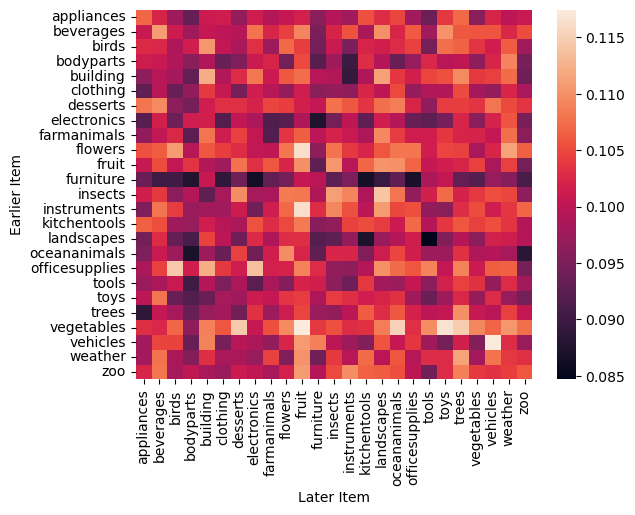

In [53]:
g = sns.heatmap(across_list_WORD_rsa_category_mat)
g.set(xlabel='Later Item', ylabel='Earlier Item')

This doesn't look like much -- the diagonal structure isn't super apparent. One reason is that there is a lot of uncontrolled variance here. Some subjects' neural activity is more category driven than others so the average similarities vary a lot by subject. It also varies by session and list. Use the split apply combine approach to see what the variability in average similarity looks like across subjects. Use seaborn [displot](https://seaborn.pydata.org/generated/seaborn.displot.html) to investigate

What we are really interested in is, within a subject and a pair of lists, do same category words look more similar than across category? Therefore we'll subtract the average similarity within a pair of lists from the `corr_z` column. This gives us only the within-list-pair variance. This is often a [good strategy](https://www.tqmp.org/RegularArticles/vol01-1/p042/p042.pdf) for visualizing effects in studies like this where there is hierarchical structure in the design (subjects/sessions/lists). We'll store this in the `corr_z_list_adj` column

In [54]:
across_list_WORD_rsa_df['corr_z_list_mean'] = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2'])['corr_z'].transform('mean')
across_list_WORD_rsa_df['corr_z_list_adj'] = (across_list_WORD_rsa_df['corr_z'] - 
                                                     across_list_WORD_rsa_df['corr_z_list_mean'])
within_list_WORD_rsa_df['corr_z_list_mean'] = within_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD'])['corr_z'].transform('mean')
within_list_WORD_rsa_df['corr_z_list_adj'] = (within_list_WORD_rsa_df['corr_z'] - 
                                                     within_list_WORD_rsa_df['corr_z_list_mean'])

/tmp/ipykernel_80346/3905098452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  across_list_WORD_rsa_df['corr_z_list_mean'] = across_list_WORD_rsa_df.groupby(
/tmp/ipykernel_80346/3905098452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  across_list_WORD_rsa_df['corr_z_list_adj'] = (across_list_WORD_rsa_df['corr_z'] -
/tmp/ipykernel_80346/3905098452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [55]:
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_category_df = across_list_WORD_rsa_session_df.groupby(
    ['category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})

In [56]:
across_list_WORD_rsa_category_df = across_list_WORD_rsa_category_df.query(
    '(category_WORD != "fabric") and ' + 
    '(category_WORD2 != "fabric")')
across_list_WORD_rsa_category_mat = across_list_WORD_rsa_category_df.pivot_table(
    index=['category_WORD'], columns=['category_WORD2'], 
    values='corr_z_list_adj')

[Text(0.5, 23.52222222222222, 'Later Item'),
 Text(50.72222222222221, 0.5, 'Earlier Item')]

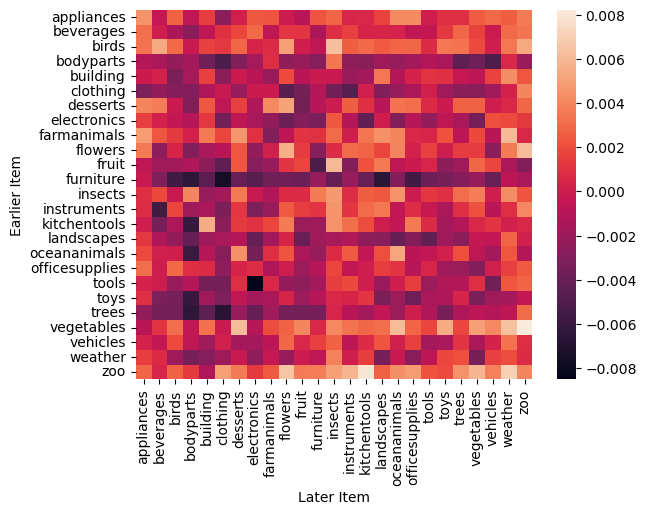

In [57]:
g = sns.heatmap(across_list_WORD_rsa_category_mat)
g.set(xlabel='Later Item', ylabel='Earlier Item')

This still doesn't look amazing, you can't really see a diagonal unless you really squint. It's challenging to see effects like this at some level because of the range of electrodes you get across patients. However, we can focus our analysis a little more. Let's see if same category comparisons are more similar than across in general.

In [58]:
across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'same_category'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'same_category'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'same_category'], as_index=False
).agg({'corr_z_list_adj': 'mean'})

/tmp/ipykernel_80346/1890595422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


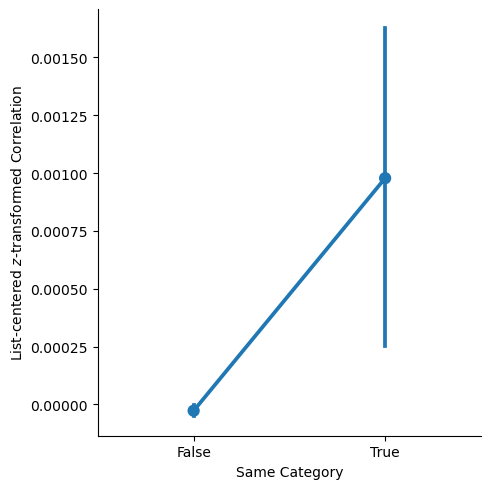

In [59]:
g = sns.catplot(x='same_category', y='corr_z_list_adj', 
            data=across_list_WORD_rsa_subject_df, kind='point')
g.set(xlabel='Same Category', ylabel='List-centered $z$-transformed Correlation')

Now we can see that there is in fact a difference, although it is somewhat small. In contrast, we would not have been able to see this without subtracting out the list mean.

In [60]:
across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'same_category'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'same_category'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'same_category'], as_index=False
).agg({'corr_z': 'mean'})

/tmp/ipykernel_80346/3445182721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


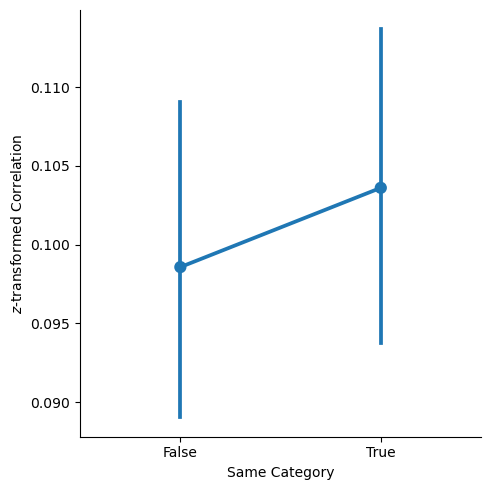

In [61]:
g = sns.catplot(x='same_category', y='corr_z', 
            data=across_list_WORD_rsa_subject_df, kind='point')
g.set(xlabel='Same Category', ylabel='$z$-transformed Correlation')

# Serial position similarity

The next set of results we'll investigate are from [Manning et al. (2011)](https://www.pnas.org/doi/10.1073/pnas.1015174108). The first result that Manning showed was that neural activity seemed to drift such that the similarity of patterns of intracranial EEG decreased as a function of distance in the list.

<center>
    <img src="figures/MannEtal11A.png" width=400>
</center>

We'll again do this analysis within list. Try to follow what we did above but this time, instead of comparing two categories, we will compare two serial positions. The relevant columns are `serialpos_WORD` and `serialpos_WORD2`. Try to make a heatmap of all of the comparisons

From this heatmap, we can clearly see how the similarity increases as a function of distance. We can replot this data as a function of distance to look a bit more like the Manning et al. plot. The following line will help you out:

In [62]:
within_list_WORD_rsa_df['serialpos_dist'] = within_list_WORD_rsa_df['serialpos_WORD2'] - within_list_WORD_rsa_df['serialpos_WORD']

/tmp/ipykernel_80346/4059334785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  within_list_WORD_rsa_df['serialpos_dist'] = within_list_WORD_rsa_df['serialpos_WORD2'] - within_list_WORD_rsa_df['serialpos_WORD']


We'll also show that being from the same category influences similarity on top of the serial position distance within a list. It's crucial to account for both at the same time because of the category structure of the list. Use the split-apply-combine technique with both `serialpos_dist` and `same_category` to get the mean within each possible combination. Use the [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) parameter `hue` to display both variables on the same plot.